In [1]:
!pip install transformers 
!pip install Datasets
!pip install hopsworks

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import numpy as np
import hopsworks


In [ ]:
#Run this if you are going to upload the dataset locally
df = pd.read_csv ("cleanedTweetData.csv")

In [4]:
#Run this if you are going to load your data from hopsworks

project = hopsworks.login()
fs = project.get_feature_store()
tweet_fg = fs.get_feature_group(name="elon_musk_tweets_modal", version=1)
df = tweet_fg.read()


Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/4251


Connected. Call `.close()` to terminate connection gracefully.


In [8]:
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

17.157272318272383


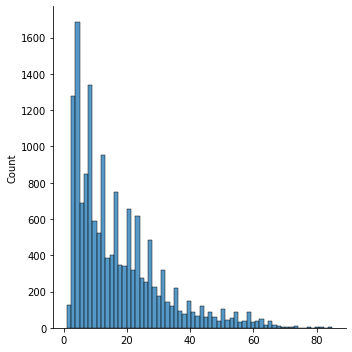

In [9]:
doc_lengths = []

for elem in df["tweet"]:

    # get rough token count distribution
    tokens = nltk.word_tokenize(elem)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.displot(doc_lengths)

print(np.average(doc_lengths))

In [10]:
from transformers import GPT2Tokenizer
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', 
                                          bos_token='<|startoftext|>', 
                                          eos_token='<|endoftext|>', 
                                          pad_token='<|pad|>') #


Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [11]:
training_examples = f'<|startoftext|> ' + df["tweet"] + '<|endoftext|>'

print(training_examples[0])

<|startoftext|> @westcoastbill Thanks Bill<|endoftext|>


In [12]:
task_df = pd.DataFrame({'text': training_examples})

task_df.head(5)

,text
0,<|startoftext|> @westcoastbill Thanks Bill<|en...
1,<|startoftext|> @nextspaceflight @NASASpacefli...
2,<|startoftext|> @Rainmaker1973 Yup<|endoftext|>
3,<|startoftext|> @nextspaceflight @Erdayastrona...
4,<|startoftext|> @flcnhvy This https://t.co/kX...


In [13]:
from datasets import Dataset

tweet_data = Dataset.from_pandas(task_df)  # turn a pandas DataFrame into a Dataset

def preprocess(example):  # tokenize our text but don't pad because our collator will pad for us dynamically
    return tokenizer( example['text'], truncation=True)

tweet_data = tweet_data.map(preprocess, batched=False)

tweet_data = tweet_data.train_test_split(train_size=.8)

  0%|          | 0/15559 [00:00<?, ?ex/s]

In [14]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

In [15]:
from transformers import GPT2LMHeadModel

model = GPT2LMHeadModel.from_pretrained('gpt2')
model.resize_token_embeddings(len(tokenizer))

Downloading:   0%|          | 0.00/548M [00:00<?, ?B/s]

Embedding(50259, 768)

In [16]:
import torch
device = torch.device("cuda")

model.to(device)
model.eval()

prompt = "<|startoftext|> Good assessment"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=20, 
                                max_length = 300,
                                top_p=0.98, 
                                num_return_sequences=10,
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257,  4599,  8922]], device='cuda:0')
0:  Good assessment


1:  Good assessment


2:  Good assessment


3:  Good assessment


4:  Good assessment


5:  Good assessment


6:  Good assessment


7:  Good assessment


8:  Good assessment


9:  Good assessment




In [17]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./tweets",
    overwrite_output_dir=True, #overwrite the content of the output directory
    num_train_epochs= 5, # number of training epochs
    per_device_train_batch_size=32, # batch size for training
    per_device_eval_batch_size=16,  # batch size for evaluation
    load_best_model_at_end=True,
    logging_steps=5,
    log_level='info',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate= 5e-4,
    warmup_steps=100,
    #weight_decay = 0.001,
    seed= 42,
    
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tweet_data["train"],
    eval_dataset=tweet_data["test"],
    data_collator=data_collator,
)

In [18]:
# train model
trainer.train()

The following columns in the training set don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: text. If text are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 12447
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1945
  Number of trainable parameters = 124441344


Epoch,Training Loss,Validation Loss


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-18-b7e217745f1c>", line 2, in <module>
    trainer.train()
  File "/usr/local/lib/python3.8/dist-packages/transformers/trainer.py", line 1527, in train
    return inner_training_loop(
  File "/usr/local/lib/python3.8/dist-packages/transformers/trainer.py", line 1777, in _inner_training_loop
    if (
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2040, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/pyt

KeyboardInterrupt: ignored

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


In [ ]:
model.push_to_hub("#Some name for your model")

Configuration saved in /tmp/tmpx2ev0pht/config.json
Model weights saved in /tmp/tmpx2ev0pht/pytorch_model.bin
Uploading the following files to davidt123/Final-GPT-2-Elon-Model: config.json,pytorch_model.bin


CommitInfo(commit_url='https://huggingface.co/davidt123/Final-GPT-2-Elon-Model/commit/c16a2ebe95ef277044e528760c24fc29e09e1153', commit_message='Upload model', commit_description='', oid='c16a2ebe95ef277044e528760c24fc29e09e1153', pr_url=None, pr_revision=None, pr_num=None)

Or you can save the model files and load them to your drive

In [ ]:
import os
out_dir = '/ElonTweets'
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained('./')
tokenizer.save_pretrained('./')

Configuration saved in ./config.json
Model weights saved in ./pytorch_model.bin
tokenizer config file saved in ./tokenizer_config.json
Special tokens file saved in ./special_tokens_map.json
added tokens file saved in ./added_tokens.json


('./tokenizer_config.json',
 './special_tokens_map.json',
 './vocab.json',
 './merges.txt',
 './added_tokens.json')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!zip -r /content/FinalModelGPT2.zip /content/FinalModelGPT2

  adding: content/FinalModelGPT2/ (stored 0%)
  adding: content/FinalModelGPT2/config.json (deflated 51%)
  adding: content/FinalModelGPT2/added_tokens.json (deflated 20%)
  adding: content/FinalModelGPT2/vocab.json (deflated 68%)
  adding: content/FinalModelGPT2/special_tokens_map.json (deflated 78%)
  adding: content/FinalModelGPT2/merges.txt (deflated 53%)
  adding: content/FinalModelGPT2/tokenizer_config.json (deflated 73%)
  adding: content/FinalModelGPT2/pytorch_model.bin (deflated 9%)
  adding: content/FinalModelGPT2/.ipynb_checkpoints/ (stored 0%)
